In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import figure

In [2]:
class tender:

  def getquery(self,url,results):
    try:  
      URL=url
      page=requests.get(URL)
      soup=BeautifulSoup(page.content,"html.parser")
      tender = soup.find_all("div",{"class":"search-result"})
      for items in tender:
          query = {
          "title": items.find('div',{'class':'search-result-header'}).text,
          "dept" : items.find('div',{'class':'search-result-sub-header wrap-text'}).text,
          "procurement_stage":(items.find_all('div',{"class":"search-result-entry"})[0].text),
          "notice_status": (items.find_all('div',{"class":"search-result-entry"})[1].text),
          "closing date" :(items.find_all('div',{"class":"search-result-entry"})[2].text),
          "contract location": (items.find_all('div',{"class":"search-result-entry"})[3].text),
          "contract_value":(items.find_all('div',{"class":"search-result-entry"})[4].text),
          "publication_date":(items.find_all('div',{"class":"search-result-entry"})[-1].text)
          }    
          results.append(query)
      return results
    except:
      return 0  
  
  def cleandata(self,df):
    try:
      df['procurement_stage'] =df['procurement_stage'].str.replace("Procurement stage","")
      df['notice_status'] =df['notice_status'].str.replace("Notice status","")
      df['contract location'] =df['contract location'].str.replace("Contract location","")
      df['title']=df['title'].str.replace("\n\t\t\t","")
      df['publication_date'] =df['publication_date'].str.replace("Publication date","")
      df['contract_value']=df['contract_value'].str.replace("Contract value","")
      print("Cleaning data complete")
      return
    except:
      return 0  

  def process(self,df):  
    try:
      df['contract location'].value_counts()
      df3 = df["contract_value"].str.split(" ", n = 4, expand = True)
      df3[3]=df3[3].str.replace("£","")
      df['contract_value']=df3[3]
      df['contract_value'] =df['contract_value'].fillna(0)

      df['procurement_stage'].value_counts()
      pubdate= df['publication_date'].str.split("\s\d\d\d\d ",expand =True)
      pubyear = pubdate[0].str.findall(r'(\d+\d+\d+\d+)').apply(lambda x: pd.Series(x).astype(int))
      df['publication_date']=pubyear[0]
      df['publication_year'] = df['publication_date']
      df.drop(columns=['publication_date'])

      closdate= df['closing date'].str.split("\d\d\d\d ",expand =True)
      closyear = closdate[0].str.findall(r'(\d+\d+\d+\d+)').apply(lambda x: pd.Series(x).astype(int))
      df['closing_year']= closyear
      clos = closdate[0].str.split(" ",n=5, expand = True)
      df['status'] = clos[0]
      df.drop(columns=['closing date'],inplace = True)
      print("Processing data complete")
      return
    except: 
      return 0  

  def contractnan(self,df):
    df['contract_value'] = df["contract_value"].str.replace(",","")
    df['contract_value'] = df['contract_value'].replace(0,np.NaN)
    list1 = (df['contract_value'].unique())
    df['contract_value'] = df['contract_value'].str.replace("January","0")
    df['contract_value'] = df['contract_value'].str.replace("February","0")
    df['contract_value'] = df['contract_value'].str.replace("March","0")
    df['contract_value'] = df['contract_value'].str.replace("April","0")
    df['contract_value'] = df['contract_value'].str.replace("May","0")
    df['contract_value'] = df['contract_value'].str.replace("June","0")
    df['contract_value'] = df['contract_value'].str.replace("July","0")
    df['contract_value'] = df['contract_value'].str.replace("August","0")
    df['contract_value'] = df['contract_value'].str.replace("September","0")
    df['contract_value'] = df['contract_value'].str.replace("October","0")
    df['contract_value'] = df['contract_value'].str.replace("November","0")
    df['contract_value'] = df['contract_value'].str.replace("December","0")
    df['contract_value'] = df['contract_value'].replace(0,np.NaN)
    df['contract_value'] = df['contract_value'].astype(float)  
    return

  def generate_csv(self,df):
    try:
      df.to_csv('uktender.csv')
      print("Generated csv")
    except:
      return 0  

In [3]:
if __name__ == '__main__':    
  ob=tender()
  resultss=[]
  for num in range(1,112):
      a ="https://www.contractsfinder.service.gov.uk/Search/Results?&page="
      b =str(num)
      c ="#dashboard_notices"
      URL = a + b + c
      ob.getquery(URL,resultss) 
  print("Data recieved, ready for processing")   
  df2=pd.DataFrame(resultss)

  ob.cleandata(df2)
  ob.process(df2)
  df2.drop(columns="publication_date",inplace=True)
  ob.contractnan(df2)
  ob.generate_csv(df2)
  df2.head(20)

Data recieved, ready for processing
Cleaning data complete
Processing data complete
Generated csv


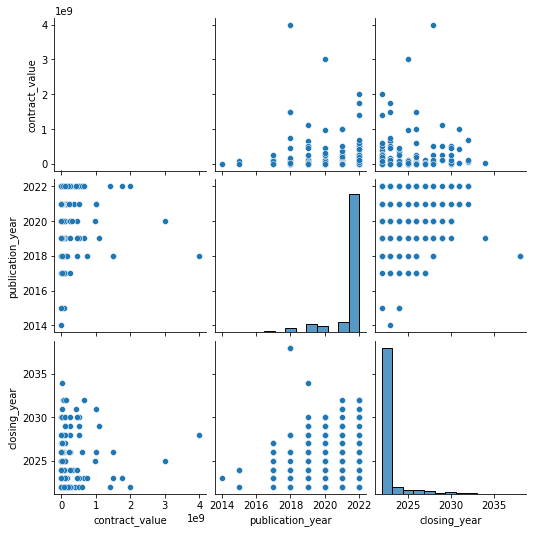

In [4]:
sns.pairplot(df2)

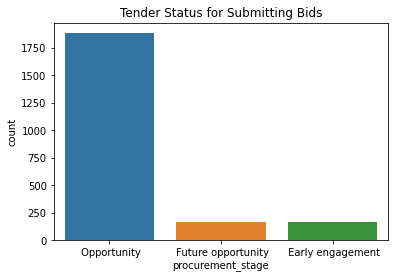

In [5]:
plt.title("Tender Status for Submitting Bids")
sns.countplot(x=df2['procurement_stage'])

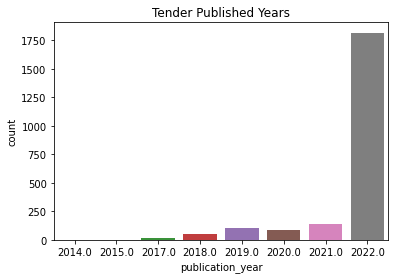

In [6]:
plt.title("Tender Published Years")
sns.countplot(x=df2['publication_year'])

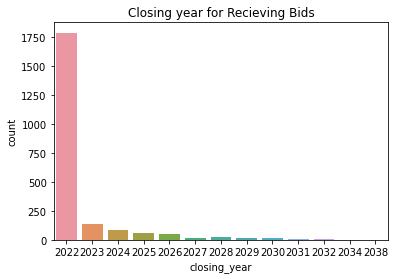

In [7]:
plt.title("Closing year for Recieving Bids")
sns.countplot(x=df2['closing_year'])

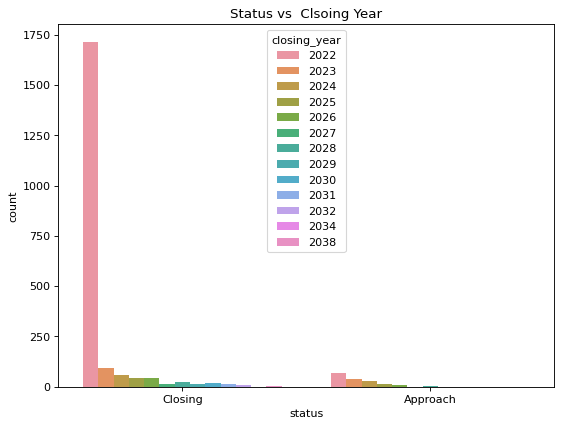

In [8]:
figure(figsize=(8, 6), dpi=80)
plt.title("Status vs  Clsoing Year")
sns.countplot(x=df2['status'],hue=df2['closing_year'])